# PSET 2 - Machine Learning

### Trent Potter - 5/14/25


In [1]:
!pip install datasets > /dev/null 2>&1

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# **Task: Unsupervised Learning**

For Unsupervised Learning Task, you'll follow these steps:

- 3.1 Explore and cluster the data.
- 3.2 Apply PCA to the data.
- 3.3 Wine recommendation.


### **3.1 Explore and cluster the data**

We load the wine dataset from Scikit-learn's built-in collection, including features and target labels.
This dataset contains information on different chemical properties of wines, which will be useful
for the clustering and and PCA analysis.


In [3]:
df = load_wine(as_frame=True)
df = df.frame
df = df.drop(columns=["target"])
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Before proceeding with the analysis, we scale the data. This step standardizes the range of the
features, preventing variables with larger scales from dominating the results.


In [4]:
scaler = StandardScaler()

features = scaler.fit(df)
features = features.transform(df)

scaled_df = pd.DataFrame(features, columns=df.columns)
scaled_df.head()

X = scaled_df.values

Next, we apply K-means clustering to the scaled data, determining the optimal number of clusters
using the elbow method. The elbow method helps identify the point where adding more clusters no
longer significantly improves the model’s performance, allowing us to choose the ideal number of
clusters for our analysis.


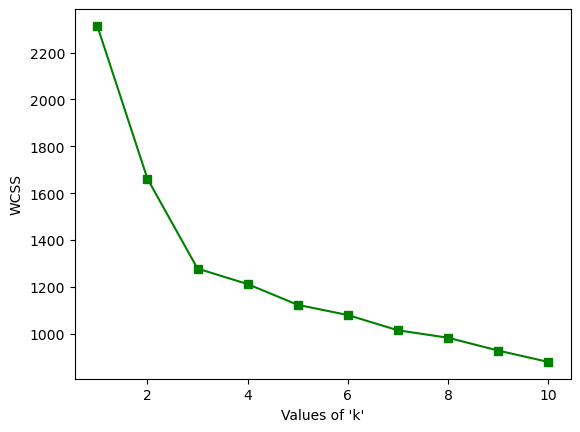

In [7]:
wcss = {}
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(X)
    wcss[i] = kmeans.inertia_

plt.plot(wcss.keys(), wcss.values(), "gs-")
plt.xlabel("Values of 'k'")
plt.ylabel("WCSS")
plt.show()

**Question:** Based on the elbow method, how many clusters would you choose for the K-means
clustering? Explain your reasoning. Use an LLM to figure out what WCSS stands for.


**Answer:**

3 or 4 seem like reasonable answers given the 'elbow' of the plot. The elbow method involves plotting the Within-Cluster Sum of Squares (WCSS) against the number of clusters. WCSS measures the total squared distance between each point and the centroid of its assigned cluster—a lower WCSS indicates tighter clusters. As the number of clusters increases, WCSS decreases, but after a certain point, the rate of decrease slows down. The "elbow" point on the plot is where this change in rate occurs, suggesting an optimal balance between model complexity and explained variance. In this case, the elbow appears at 3 or 4 clusters, so either would be a justified choice for K-means clustering.


In [9]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

### **3.2 Apply PCA to the data**

Now, we apply Principal Component Analysis (PCA) to reduce the dimensionality of the data, extracting the first two principal components. This allows us to visualize the data in two dimensions while preserving most of the variance.


In [10]:
num_components = df.shape[1]
pca = PCA(n_components=num_components)
reduced_X = pd.DataFrame(
    data=pca.fit_transform(X), columns=[f"PC{i}" for i in range(1, num_components + 1)]
)
centers = pca.transform(kmeans.cluster_centers_)

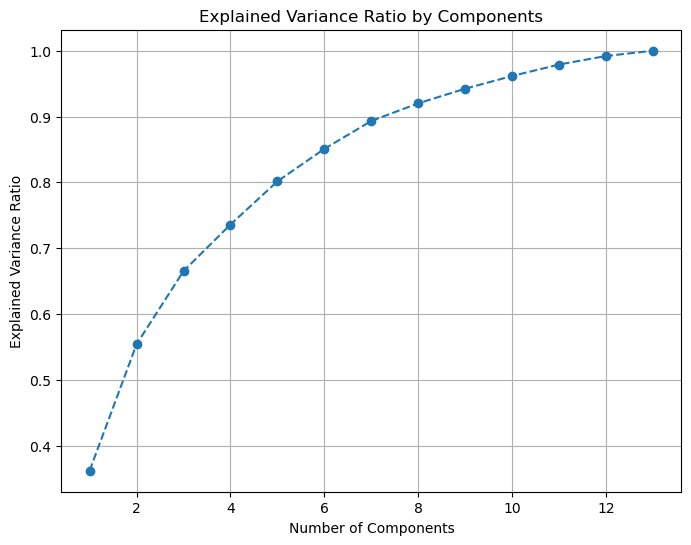

In [11]:
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(
    range(1, num_components + 1), explained_variance_ratio, marker="o", linestyle="--"
)
plt.title("Explained Variance Ratio by Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

**Question:** How many principal components should be selected to explain at least 80% of the variance in the dataset?
**Answer:**
5 components


We now visualize the first two principal components, with the data points colored according to their cluster assignments. This visualization helps us understand how the clusters are distributed in the reduced two-dimensional space.


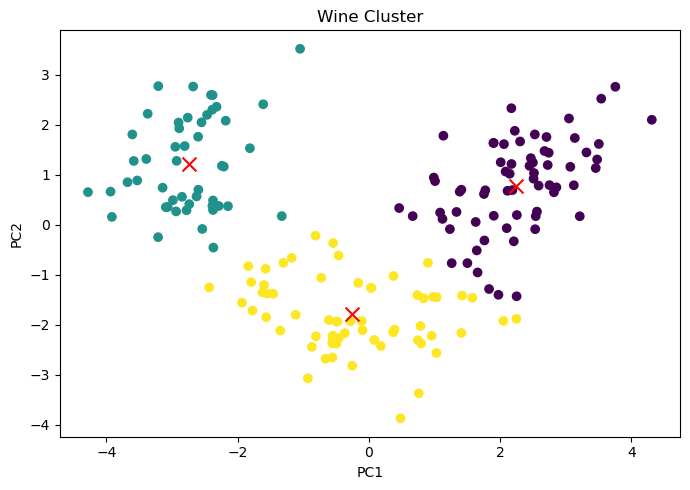

In [12]:
plt.figure(figsize=(7, 5))

# Scatter plot
plt.scatter(reduced_X["PC1"], reduced_X["PC2"], c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:, 1], marker="x", s=100, c="red")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wine Cluster")
plt.tight_layout()

Now, let's take a look at how each feature loads onto the first two principal components. This will show us which features have the biggest impact on the data’s variance in the reduced space.


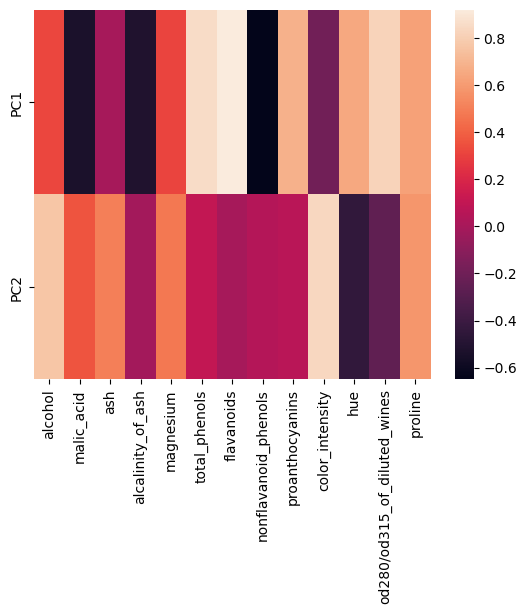

In [13]:
component_df = pd.DataFrame(
    (pca.components_[:2, :].T * np.sqrt(pca.explained_variance_[:2])).T,
    index=["PC1", "PC2"],
    columns=df.columns,
)
# Heat map
sns.heatmap(component_df)
plt.show()

The following interactive scatter plot shows the first two principal components of the wine dataset, with data points color-coded by cluster assignment. You can select different features from the dropdown to visualize how each feature is distributed across these two principal components. This allows us to explore how the features relate to the two principal components.


In [14]:
def plot_scatter(variable):
    plt.figure(figsize=(10, 7))

    # Scatter plot with cluster colors
    scatter = plt.scatter(
        reduced_X["PC1"],
        reduced_X["PC2"],
        c=kmeans.labels_,
        cmap="viridis",
        s=30,
        alpha=0.7,
    )

    # Plot cluster centers
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="x",
        s=150,
        c="red",
        label="Cluster Centers",
    )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Wine Cluster with Annotated Labels")
    plt.legend()

    # Introduce small random noise to avoid overlap
    np.random.seed(42)  # For consistent results
    x_offsets = np.random.uniform(-0.2, 0.2, len(df))
    y_offsets = np.random.uniform(-0.2, 0.2, len(df))

    # Annotate points with the chosen variable
    for i, txt in enumerate(df[variable]):
        plt.annotate(
            txt,
            (reduced_X["PC1"][i] + x_offsets[i], reduced_X["PC2"][i] + y_offsets[i]),
            fontsize=8,
            ha="center",
            va="center",
        )

    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the variable

dropdown = widgets.Dropdown(
    options=df.columns,
    value="alcohol",
    description="Variable:",
    disabled=False,
)

# Use interact to create an interactive plot
widgets.interact(plot_scatter, variable=dropdown)


interactive(children=(Dropdown(description='Variable:', options=('alcohol', 'malic_acid', 'ash', 'alcalinity_o…

<function __main__.plot_scatter(variable)>

By default, the dropdown above is set to alcohol, which has a strong influence on the second principal component (PC2). You will notice that higher alcohol values tend to cluster at higher PC2 values. Similarly, malic acid plays a significant role in the first principal component (PC1). If you select malic_acid from the dropdown, you'll observe that large values of malic acid are primarily found at lower PC1 values. This reflects how the PCA transformation captures variations in the dataset, with PC1 and PC2 separating the features into distinct clusters.


### **3.3 Wine recommendation**

In this task, we’ll apply everything we’ve learned so far to find the perfect bottle of wine for a birthday party.
You're invited to a celebration and want to bring an excellent Swiss wine. You already know a wine your friend enjoys and hope to find a similar one—but not the exact same!
To identify comparable wines, we’ll use a dataset that focuses specifically on Swiss varieties, as the previous dataset included a broader selection. Let's begin by loading the new dataset.


In [15]:
swiss_wine = pd.read_csv(
    "https://raw.githubusercontent.com/chansen776/MBA-ML-Course-Materials/refs/heads/main/Data/wines_data.csv"
)
swiss_wine.head()

,Winery,Alkohol,Gesamtsäure,Restzucker,Rebsorte,Jahrgang,Region
0,Schwarzenbach,13.2,5.45,1.6,Räuschling,2022,Deutschweiz
1,St. Jodern Kellerei,13.6,3.54,2.4,Heida,2022,Wallis
2,Mounir Weine,13.4,3.37,2.3,Cave du Rhodan,2021,Wallis
3,Caves du Chambleau,13.8,4.94,1.3,Pinot Noir,2021,Drei-Seen Region
4,Grand'Cour,14.0,4.34,1.0,Cabernet Frac,2020,Genf


Your friend enjoys wine from the Schwarzenbach winery, and you'd like to find similar options. To do this, we'll first cluster the data to group similar wines. Then, for better visualization, we'll reduce the dimensionality to two so we can represent the results graphically.


In [16]:
# Clustering
swiss_wine_numeric = swiss_wine[["Alkohol", "Gesamtsäure", "Restzucker", "Jahrgang"]]
swiss_wine_numeric = scaler.fit_transform(swiss_wine_numeric)
kmeans = KMeans(n_clusters=3)
kmeans.fit(swiss_wine_numeric)

KMeans(n_clusters=3)

In [17]:
# Dimensionality Reduction
pca = PCA(n_components=2)
scaler = StandardScaler()
swiss_wine_numeric = scaler.fit_transform(swiss_wine_numeric)
reduced_swiss_wine = pca.fit_transform(swiss_wine_numeric)

Now, we're ready to identify similar wines. To visualize the results, we'll plot the first two principal components and annotate each point with its corresponding cluster label. This will help us see how the wines are grouped and identify those most similar to the ones from Schwarzenbach.


Winery         Schwarzenbach
Alkohol                 13.2
Gesamtsäure             5.45
Restzucker               1.6
Rebsorte          Räuschling
Jahrgang                2022
Region           Deutschweiz
Name: 0, dtype: object


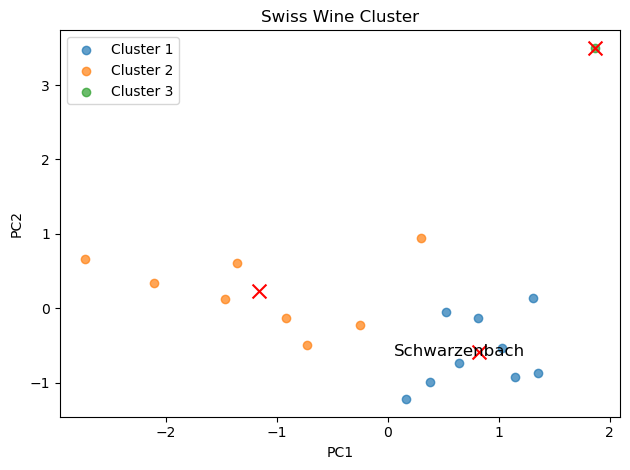

In [18]:
centers = pca.transform(kmeans.cluster_centers_)
for cluster_id in range(kmeans.n_clusters):
    plt.scatter(
        reduced_swiss_wine[kmeans.labels_ == cluster_id, 0],  # PC1
        reduced_swiss_wine[kmeans.labels_ == cluster_id, 1],  # PC2
        label=f"Cluster {cluster_id + 1}",  # Assign proper cluster labels
        alpha=0.7,
    )

plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="x",
    s=100,
    c="red",
)

point_index = 0
x_point, y_point = reduced_swiss_wine[point_index]
print(swiss_wine.iloc[point_index])

plt.text(
    x_point,
    y_point + 0.1,
    "Schwarzenbach",
    fontsize=12,
    ha="center",
    color="black",
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Swiss Wine Cluster")
plt.legend()
plt.tight_layout()
plt.show()

**Question:** Wines from which clusters would you recommend? Pick one cluster (1/2/3) and see which wines you should
bring to your friend's party.


**Answer:**
From cluster 1, it's similar to Schwarzenbach.


In [19]:
# Pick you cluster
cluster_id = 1
swiss_wine[kmeans.labels_ == cluster_id - 1]

,Winery,Alkohol,Gesamtsäure,Restzucker,Rebsorte,Jahrgang,Region
0,Schwarzenbach,13.2,5.45,1.6,Räuschling,2022,Deutschweiz
3,Caves du Chambleau,13.8,4.94,1.3,Pinot Noir,2021,Drei-Seen Region
4,Grand'Cour,14.0,4.34,1.0,Cabernet Frac,2020,Genf
5,Pircher,14.1,5.39,0.7,Pinot Noir,2020,Deutschschweiz
6,Castello di Morcote,13.5,5.94,0.7,Merlot,2020,Tessin
7,Wegelin,13.3,6.16,0.7,Pinot Gris,2022,Deutschschweiz
9,Schmidheiny,13.5,5.33,0.3,Pinot Noir,2022,Deutschschweiz
10,Osterfingen,13.0,4.87,1.3,Pinot Blanc,2022,Deutschschweiz
15,Domaine du Clos des Pins,13.4,4.63,0.6,Gamaret,2021,Genf


# **Task:** Transfer Learning with PACS (Photo-Art-Cartoon-Sketch) Dataset


## Setup

Import necessary libraries and define basic settings like training/testing domains, batch size, number of epochs, and device.


In [20]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import ResNet18_Weights, resnet18

# Settings
train_domain = "photo"
test_domains = ["art_painting", "cartoon", "sketch"]
batch_size = 32
num_epochs = 5 # One would typically train using way more epochs. We use 5 for a quick demo.
device = torch.device("cpu")  # No GPU

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

ModuleNotFoundError: No module named 'torch'

# Problem Statement

In real-world applications, visual recognition systems often encounter data that differs in style or appearance from what they were trained on — a challenge known as **domain shift**. To build robust models that generalize well across different visual styles, we turn to **domain generalization** benchmarks.

Our objective is to **train a model that can classify objects accurately across domains**, using only the image itself as input. Specifically, we want to assess whether a model trained on images from one visual domain (e.g., natural photographs) can generalize to a significantly different domain (e.g., hand-drawn sketches), without seeing examples from the target domain during training.

---

# Dataset: PACS

To evaluate this, we use the **PACS dataset** — a popular benchmark for domain generalization and adaptation research. The dataset features four distinct visual domains:

- **Art Painting** – artistic renditions in diverse painting styles
- **Cartoon** – simplified and stylized illustrations
- **Photo** – real-world, natural images (similar to ImageNet)
- **Sketch** – black-and-white hand-drawn sketches

Each domain contains images from the **same 7 object categories**:

`['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']`

This consistent label set allows for direct cross-domain evaluation.

---

# Experimental Setup

We adopt a simplified domain generalization setup, we only train on one domain and test on all other domains.

- **Train** on: `'photo'` domain (real-world images)
- **Test** on: `'art_painting'`, `'cartoon'`, `'sketch'` domains

This tests the model’s ability to generalize from natural photos to a starkly different visual style
without access to the data of the domains during training.

---

# Load the PACS Dataset

Download the PACS dataset using Hugging Face `datasets`, and filter by the selected training and testing domains.


In [ ]:
# Load PACS dataset from Hugging Face
dataset = load_dataset("flwrlabs/pacs")

# Get class info
label_info = dataset["train"].features["label"]
num_classes = len(label_info.names)

# Filter by domain
train_dataset = dataset["train"].filter(lambda x: x["domain"] == train_domain)
test_dataset = dataset["train"].filter(lambda x: x["domain"] in test_domains)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

# Define and Apply Image Transforms

Set up separate transform pipelines for training and testing (resizing, normalization, augmentation,
etc.). Use `.with_transform()` to apply preprocessing transforms to each domain dataset.


In [ ]:
# Image transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply transforms
def apply_transform(batch, transform):
    batch["image"] = [transform(img) for img in batch["image"]]
    return batch

train_dataset = train_dataset.with_transform(lambda batch: apply_transform(batch, transform_train))
test_dataset = test_dataset.with_transform(lambda batch: apply_transform(batch, transform_test))

# Visual Inspection

Let's have a look at typical images of the training and test domain.


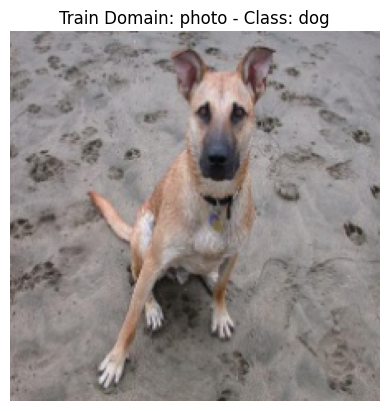

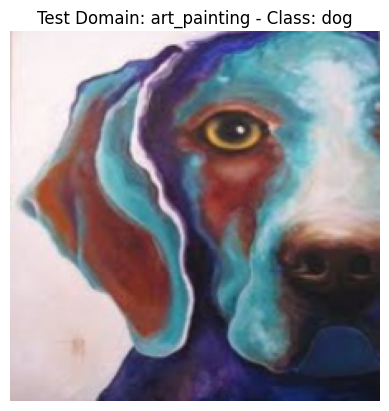

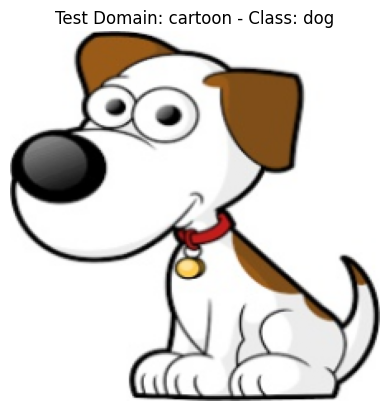

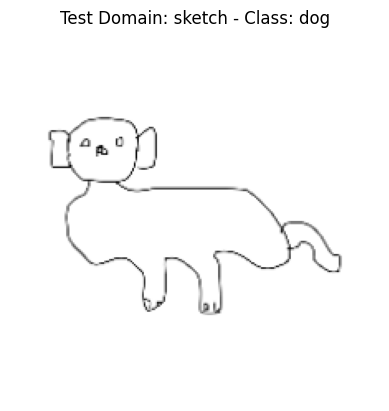

In [ ]:
def show_example(dataset, label_names, title):
    example = dataset[1]  # safer to use 0 than 1 in case dataset is small
    img = example["image"]
    label = example["label"]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"{title} - Class: {label_names[label]}")
    plt.axis("off")
    plt.show()


# Show example from training domain
show_example(train_dataset, label_info.names, f"Train Domain: {train_domain}")

# Show example(s) from test domain(s)
for domain in test_domains:
    for example in test_dataset:
        if example["domain"] == domain:
            img = example["image"]
            label = example["label"]
            plt.imshow(img.permute(1, 2, 0))
            plt.title(f"Test Domain: {domain} - Class: {label_info.names[label]}")
            plt.axis("off")
            plt.show()
            break

# DataLoader Sanity Check

Create PyTorch DataLoaders and inspect a batch to verify image shapes and labels.


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Sanity check
batch = next(iter(train_loader))
print(type(batch["image"]))
print(batch["image"].shape)
print(batch["label"])

<class 'torch.Tensor'>
torch.Size([32, 3, 224, 224])
tensor([2, 2, 6, 6, 3, 6, 2, 0, 6, 4, 0, 5, 0, 0, 2, 6, 6, 6, 0, 6, 0, 1, 6, 4,
        5, 6, 1, 6, 6, 2, 6, 6])


# Model Setup: ResNet-18

For image classification tasks, convolutional neural networks (CNNs) are commonly used due to their ability to extract spatial features from images. In this notebook, we use a **pretrained ResNet-18** model, a lightweight yet effective architecture.

We replace the final fully connected layer to match the number of classes in our dataset. To reduce computational load, we **freeze the backbone** of the network and fine-tune only the classifier head. This approach allows us to adapt the model to our specific task without retraining the entire network, which is especially useful when working on CPUs or with limited resources.


In [ ]:
# Model setup (ResNet18)
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only classifier
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


# State-of-the-Art CNNs

Recent advancements in convolutional neural networks and hybrid architectures have led to highly accurate, large-scale models. These state-of-the-art architectures are commonly used in cutting-edge applications and typically require significant compute resources such as multi-GPU or TPU setups.

Below is a list of modern architectures, along with **ResNet-18** for comparison, which remains a popular baseline due to its simplicity and efficiency.

| Model                | Parameters | ImageNet Top-1 Accuracy | Highlights                                                                          |
| -------------------- | ---------- | ----------------------- | ----------------------------------------------------------------------------------- |
| **CoAtNet-7**        | ~2.44B     | ~90.88%                 | Hybrid model combining convolution and attention; excels on large-scale tasks       |
| **ViT-G/14**         | ~1.84B     | ~90.45%                 | Giant Vision Transformer achieving top-tier performance on ImageNet                 |
| **EfficientNetV2-L** | ~120M      | ~85.7%                  | Efficient architecture found via neural architecture search (NAS)                   |
| **RegNetY-32GF**     | ~145M      | ~82.9%                  | Balances performance and efficiency; part of the RegNet design space                |
| **ResNet-18**        | ~11.7M     | ~69.8%                  | Lightweight CNN; widely used in resource-constrained and rapid prototyping settings |

---

# Why Use ResNet-18?

**ResNet-18** is a much smaller network with only **~11.7 million parameters**. While it is no longer considered state-of-the-art in terms of accuracy, it remains a strong baseline due to its:

- Fast training on CPU or resource-limited environments
- Solid generalization capabilities
- Simplicity and interpretability

In this notebook, we use ResNet-18 due to **computational constraints** and the need for efficient training during domain adaptation tasks.


In [ ]:
# Initialize lists to track training performance
train_losses = []
train_accuracies = []

# Training Loop

Train the model on the training domain for the specified number of epochs, tracking training loss and accuracy throughout.  
**Note:** Training takes approximately 30 minutes. You don't necessarily need to run the code, as the results are already computed (see below).


In [ ]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total * 100
    train_losses.append(running_loss)
    train_accuracies.append(acc)
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {running_loss:.4f} - Train Acc: {acc:.2f}%")


Epoch 1/5 - Loss: 78.6781 - Train Acc: 51.98%
Epoch 2/5 - Loss: 37.8130 - Train Acc: 88.92%
Epoch 3/5 - Loss: 22.8226 - Train Acc: 95.81%
Epoch 4/5 - Loss: 16.2750 - Train Acc: 97.13%
Epoch 5/5 - Loss: 12.9453 - Train Acc: 97.25%


# Training Performance Visualization

Plot training loss and accuracy across epochs.


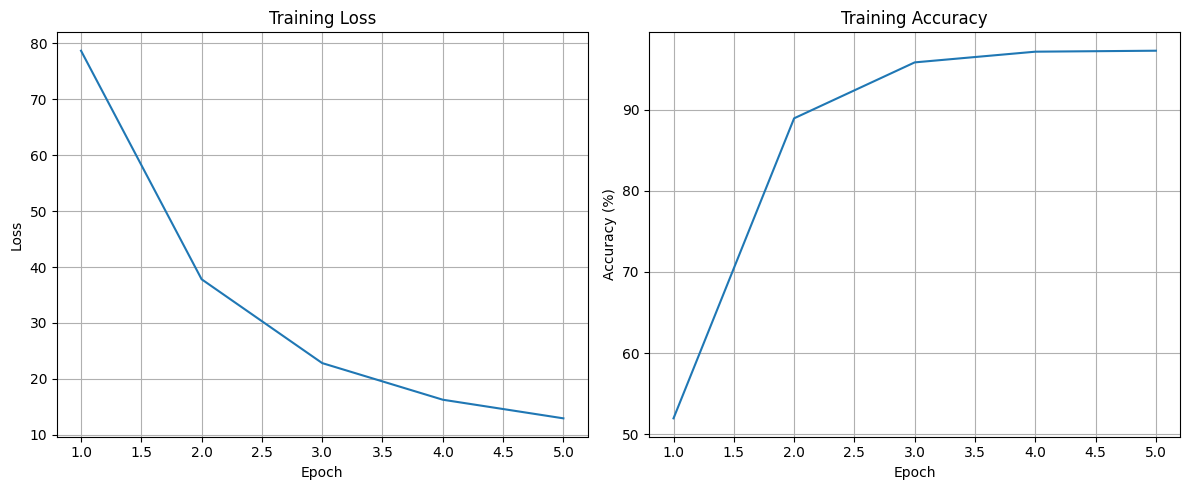

In [ ]:
epochs = list(range(1, len(train_losses) + 1))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


# Evaluation

Evaluate the model on the test domains and compute final accuracy.


# Test Accuracy Across Domains

Visualize how well the model performs on the target domains after training.


In [ ]:

domain_accuracies = {}

model.eval()
with torch.no_grad():
    for domain in test_domains:
        domain_subset = dataset["train"].filter(
            lambda x: x["domain"] == domain, load_from_cache_file=False
        )

        domain_subset = domain_subset.with_transform(
            lambda batch: apply_transform(batch, transform_test)
        )
        domain_loader = DataLoader(domain_subset, batch_size=64)

        correct = 0
        total = 0

        for batch in domain_loader:
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = correct / total * 100
        domain_accuracies[domain] = acc
        print(f"Accuracy on '{domain}': {acc:.2f}%")

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Accuracy on 'art_painting': 56.84%


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Accuracy on 'cartoon': 26.28%


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Accuracy on 'sketch': 27.67%


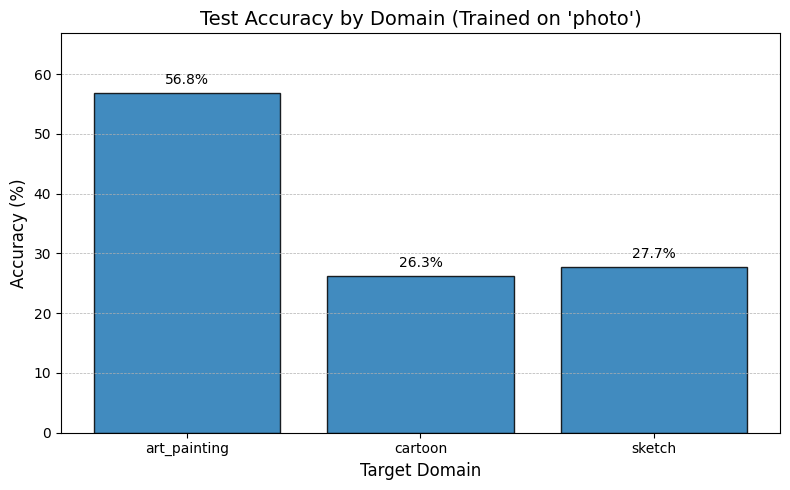

In [ ]:
domains = list(domain_accuracies.keys())
accuracies = list(domain_accuracies.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(domains, accuracies, edgecolor="black", alpha=0.85)

# Add accuracy labels on top of each bar
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval + 1,
        f"{acc:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xlabel("Target Domain", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title(f"Test Accuracy by Domain (Trained on '{train_domain}')", fontsize=14)
plt.ylim(0, max(accuracies) + 10)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


The model achieves a test accuracy of **56.8%** on the `'art_painting'` domain, 26.3% on the
`'cartoon'` domain and 27.7% on the `'sketch'` domain, compared to **97.72%** on the training domain
`'photo'`. While this is significantly
better than random guessing (which would yield about **14.3%** accuracy with 7 classes) for all test
domains, it clearly illustrates the challenge of **domain shift**.

The model was trained exclusively on `'photo'` images, and struggles to generalize to the visually
distinct test domains. This performance gap is a common issue in domain adaptation and
underscores the importance of training on **diverse and representative domains** to improve
generalization to unseen styles.

Here are some approaches to improve the performance on the test domain:

- **Train on multiple source domains**  
  Including additional domains (e.g., `'sketch'`, `'cartoon'`) during training can help the model learn more robust, domain-invariant features.

- **Use stronger data augmentation**  
  Techniques such as color jittering, random cropping, rotation, or even style transfer can simulate domain variability during training.

- **Fine-tune more layers**  
  Instead of freezing the entire backbone, selectively unfreezing the last few blocks (e.g., `layer4`) can help the model adapt better to the target domain.

- **Use a more expressive model**  
  Switching to a deeper architecture like ResNet-50 or EfficientNet (if compute allows) may improve generalization.

- **Domain adaptation techniques**  
  Explore advanced strategies like Domain-Adversarial Training (DANN), Maximum Mean Discrepancy (MMD), or CORAL to align feature distributions between source and target domains.

- **Self-training on target domain**  
  If unlabeled target data is available, semi-supervised learning (e.g. pseudo-labeling) can help bridge the domain gap.


# Question

What factors might explain the significant variation in test accuracy across different domains?
The model achieves 56.8% accuracy on the `'art_painting'` domain, 26.3% on `'cartoon'`, and 27.7% on
`'sketch'`, compared to 97.72% on the training domain `'photo'`.

Why do you think the model generalizes better to `'art_painting'` than to `''cartoon'` or `'sketch'`? What characteristics of these domains might make them more or less challenging for the model?

The model was trained exlusively on images of dogs. Given that `art_painting` may be more similar in features and composition to images than cartoons or sketches, I conjecture that these features are captured in the training set and give rise to the relative accuracy in art versus cartoons.


# Short-Answer Case Question:


Consider applying Reinforcement Learning (RL) to optimize dynamic pricing strategies in e-commerce. Reflect on the following practical considerations:

- **Measuring Success**: How would you define success in a real-world pricing system? Think about key metrics such as conversion rates, revenue, or customer satisfaction.

Success in a real-world RL-based pricing system could be measured using a combination of metrics, such as overall revenue, profit margins, conversion rates (the proportion of visitors who make a purchase), and customer satisfaction or retention. Ideally, the RL agent should optimize for long-term value, balancing immediate sales with customer loyalty and market competitiveness. Multi-objective reward functions could be used to capture these trade-offs, ensuring that pricing strategies do not maximize short-term gains at the expense of customer trust or brand reputation.

- **Training the Model**: How much time would you allocate for model training? Would you prefer to train the model over a fixed period, or allow it to continuously learn from real-time data? What are the advantages and trade-offs of each approach?

I’d lean toward continuous learning, since e-commerce markets are dynamic and customer behavior changes fast. RL models that keep learning from real-time data can adapt to new trends and competitor moves. However, this requires careful monitoring to avoid instability or exploitation of short-term anomalies. Fixed-period training is safer and easier to validate, but risks the model becoming outdated. Ideally, I’d use a hybrid: periodic retraining with ongoing fine-tuning as new data arrives.

- **Tracking States**: What states are important for dynamic pricing (e.g., market conditions, customer behavior, competitor prices)? How would you make sure these states are measurable and useful in making pricing decisions?

Important states would include current demand, inventory levels, time of day/week, customer segments, browsing history, and competitor prices. To make these states useful, I’d ensure the data is collected in real time and preprocessed into features the RL agent can use. Feature engineering and dimensionality reduction (like PCA) could help focus on the most relevant signals, reducing noise and improving learning efficiency.

- **Action Space Constraints**: What constraints would you place on the pricing model (e.g., price ranges or rate limits) to ensure practical, realistic outcomes? How would these constraints be enforced within the RL model?

I’d set minimum and maximum price limits, and possibly restrict how much the price can change in a single step (rate limits), to avoid shocking customers or violating business rules. In RL, these constraints can be enforced by clipping the action space or adding penalties to the reward function for violating constraints. This keeps the agent’s actions realistic and aligned with business policies. We could also become more creative with the objective function, adding penalty terms for any behaviors we want to manage.

- **Simulation In Practice**: How realistic do you think the simulation model for dynamic pricing is? Would you trust its predictions in a real-world setting? How would you test or validate the simulation using actual e-commerce data?

Simulations are always simplifications, so I’d be cautious about trusting them blindly. I’d validate the simulation by comparing its predictions to historical data and running A/B tests with small user groups before full deployment. Further, we'll need to be catious about endogeneous effects and how we've modeled them in our system. Continuous monitoring and feedback loops are essential—if the RL agent’s real-world performance diverges from the simulation, I’d retrain or adjust the model accordingly. Ultimately, the simulation is a starting point, but real-world testing is key for trust and effectiveness.
